## Flipkart Grid 2023, The Team
### Personalized Product Recommendations: Hybrid Approach (ALS Algorithm)

**Ajjarapu Jyothi: m22cs007@iitj.ac.in** <br>
**Devansh Kaushik: devansh007kaushik@gmail.com**

Typically, Content-Based Filtering approaches (User or Item based) recommend products using the attributes of the products. However, since the products' attributes might change with evolving demand and fashion sense, **Collaborative Filtering** approaches (Item or User-based, or both) are preferably used.

This notebook explains the implementation of the **mixed Recommender System (ALS Algorithm)** - **MF Matrix Factorization** with item similarity-based Collaborative Filtering. This hybrid approach is effective for utilizing both techniques. Collaborative Filtering is employed for non-personalized products or new users.

**Dataset**: Implicit feedback data (added to zip)






In [87]:
import pandas as pd
import numpy as np
import sys
import os
import sys;
import numpy,sklearn
from pandas import read_csv;
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
import datetime
import codecs
from bs4 import BeautifulSoup
import nltk
import os
import nltk.corpus,nltk.tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
import re
import string
import matplotlib.pyplot as plt
from pylab import *
import sklearn
from IPython import display
import ipywidgets as widgets
import sklearn.metrics as metrics
import operator
from sklearn.metrics.pairwise import cosine_similarity,pairwise_distances 
import implicit
import seaborn as sns
import os
import evaluation_func as eval
from pygments import highlight
from pygments.lexers import get_lexer_by_name, get_lexer_for_filename
from pygments.formatters import HtmlFormatter
from IPython.display import display, HTML

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   sessionId  userId  itemId action  timeframe eventdate  userID
0         48       2   24764  click       8863  4/9/2016       2
1         48       2   24764  click     496381  4/9/2016       2
2         48       2   24764  click     265216  4/9/2016       2
3         48       2   24764  click     519975  4/9/2016       2
4         48       2   24764  click     456437  4/9/2016       2
unique userId: 9999
unique itemId: 16177
avg. distinct item count per user: 3.216821682168217
avg. distinct user count per item: 1.9883167459974038


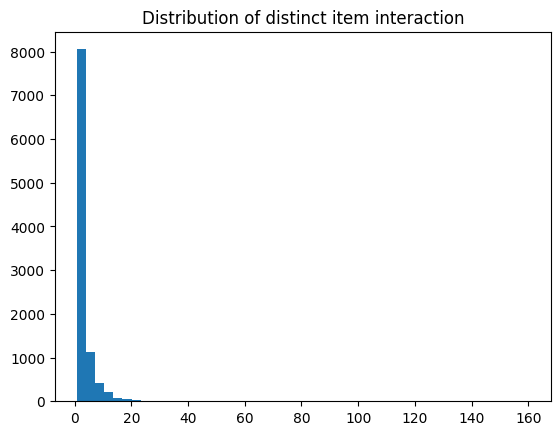

In [112]:
data = pd.read_csv("user_item_action.csv")
data['action']='click' #Adding user action(click) column 
print(data.head(5))
print('unique userId:',len(list(data['userId'].unique())))
print('unique itemId:',len(list(data['itemId'].unique())))
print('avg. distinct item count per user:',data.groupby('userId')['itemId'].nunique().mean())
print('avg. distinct user count per item:',data.groupby('itemId')['userId'].nunique().mean())
user_item_interaction = data.groupby('userId')['itemId'].nunique()
plt.hist(user_item_interaction, bins = 50)
plt.title('Distribution of distinct item interaction')
plt.show()

In [113]:
data['action'].unique()

array(['click'], dtype=object)

In [114]:
#Sorting data based on time stamp

data["timeframe"] = pd.to_datetime(pd.to_numeric(data["timeframe"]), unit="s")
data_sort = data.sort_values(by=["timeframe"],ascending=True)
data_sort['month'] = data_sort["timeframe"].dt.month
data_sort['day'] = data_sort["timeframe"].dt.day
data_sort['day'] = data_sort['day'].astype('str')
data_sort['month'] = data_sort['month'].astype('str')
data_sort['month_day'] = data_sort[['month', 'day']].apply(lambda x: ''.join(x), axis=1)
data_sort['day'] = data_sort['month'].astype('str')
data_sort['userId'] = data_sort['userId'].astype('str')
day_sr_no = {}

# Mapping external to internal days
for i in range(len(data_sort)):
    month_day = data_sort['month_day'][i]
    if month_day not in day_sr_no :
        day_sr_no[month_day] = len(day_sr_no)
month_day = list(day_sr_no.keys())
sr_no = list(day_sr_no.values())
day_sr = pd.DataFrame({'month_day':month_day,'day_seq':sr_no})     
data_sort = pd.merge(left=data_sort.reset_index(drop=True),right=day_sr.reset_index(drop=True),how='left',on='month_day')
data_sort.sort_values(["userId",'day_seq'],ascending=True,inplace=True)
data_sort['day_seq'] = data_sort['day_seq'].astype('str')
data_sort['UserID_day'] = data_sort[['userId', 'day_seq']].apply(lambda x: ''.join(x), axis=1)
data_sort[['userId','itemId']] = data_sort[['userId','itemId']].astype('object')
data_sort.drop('timeframe',axis =1).head(5)

sessionId userId itemId action  eventdate  userID month day month_day  \
2562         172     10  36602  click  2/21/2016      10     1   1        11   
27931        172     10  36602  click  2/21/2016      10     1   1        16   
28730        172     10  10691  click  2/21/2016      10     1   1        16   
23215        172     10  47373  click  2/21/2016      10     1   1        14   
27117        172     10  10858  click  2/21/2016      10     1   1        15   

      day_seq UserID_day  
2562        0        100  
27931       1        101  
28730       1        101  
23215       2        102  
27117       5        105

In [115]:
data_sort_user = data_sort[['userId','day_seq']]
data_sort_user.drop_duplicates(subset=None, keep='first', inplace=True)
user_id_repeat = pd.DataFrame(data_sort_user.groupby('userId').day_seq.nunique())
user_id_repeat['user'] = user_id_repeat.index
user_id_repeat.reset_index(drop=True, inplace = True)
user_id_repeat = user_id_repeat[(user_id_repeat['day_seq']>1)]
data_sort_user = data_sort_user[data_sort_user['userId'].isin(list(user_id_repeat['user']))]

#To get the last day for each user
max_day = data_sort_user.groupby('userId').day_seq.max()
user_id_repeat['max_day'] = max_day.values
user_id_repeat['user_day'] = user_id_repeat[['user', 'max_day']].apply(lambda x: ''.join(x), axis=1)
user_id_repeat.head(5)

C:\Users\devan\AppData\Local\Temp\ipykernel_18864\1460777721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sort_user.drop_duplicates(subset=None, keep='first', inplace=True)


day_seq   user max_day user_day
0        5     10       6      106
1        2    100       6     1006
2        3   1000       7    10007
3        2  10000       7   100007
4        3  10001       7   100017

In [93]:
data_sort_repeat = data_sort[data_sort['userId'].isin(list(user_id_repeat['user']))]
data_sort_repeat.sort_values(["userId",'day_seq'],ascending=True,inplace=True)
data_sort_repeat = data_sort_repeat[["userId",'itemId','action','day_seq','UserID_day']]
data_sort_repeat['day_seq'] = data_sort_repeat['day_seq'].astype('int')
data_sort_repeat.head(5)

C:\Users\devan\AppData\Local\Temp\ipykernel_18864\1276080907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sort_repeat.sort_values(["userId",'day_seq'],ascending=True,inplace=True)


userId itemId action  day_seq UserID_day
2562      10  36602  click        0        100
27931     10  36602  click        1        101
28730     10  10691  click        1        101
23215     10  47373  click        2        102
27117     10  10858  click        5        105

In [94]:
#Train-test-1 day test
test = data_sort_repeat[data_sort_repeat['UserID_day'].isin(list(user_id_repeat['user_day']))]
train = data_sort_repeat[~data_sort_repeat['UserID_day'].isin(list(user_id_repeat['user_day']))]
print(train.shape)
print(test.shape)

(24930, 5)
(7642, 5)


In [95]:
train[['userId', 'itemId']] = train[['userId', 'itemId']].astype(str)
train['user_item'] = train[['userId', 'itemId']].apply(lambda x: '_'.join(x), axis=1)
training = train[['user_item','action']]
training = pd.DataFrame(pd.pivot_table(training, values='action', index=['user_item'],columns=['action'], aggfunc=np.count_nonzero))
training['user_item'] = training.index
training = pd.DataFrame(np.array(training))
training.columns = ['click', 'user_item']
training.fillna(0,inplace=True)
training['userId'] = training['user_item'].apply(lambda x: str(x).split('_')[0])
training['itemId'] = training['user_item'].apply(lambda x: str(x).split('_')[1])
training.drop('user_item',axis=1,inplace=True)
training['itemId'] = training['itemId'].astype(int)
training.columns=['click', 'userId', 'itemId']
training.head(3)

C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2017333063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['userId', 'itemId']] = train[['userId', 'itemId']].astype(str)
C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2017333063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['user_item'] = train[['userId', 'itemId']].apply(lambda x: '_'.join(x), axis=1)


click userId  itemId
0     2  10000   20024
1     4  10001  109029
2     2  10001  134792

In [96]:
testing = test[['userId', 'itemId']]
testing.drop_duplicates(subset=None, keep='first', inplace=True)
testing.head(3)

C:\Users\devan\AppData\Local\Temp\ipykernel_18864\3832993150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing.drop_duplicates(subset=None, keep='first', inplace=True)


userId itemId
15115     10  10263
14104    100   3717
15547    100   3655

In [97]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
final_users = intersection(list(train['userId'].unique()),list(test['userId'].unique()))
testing = testing[testing['userId'].isin(list(final_users))]
training2 = training[training['userId'].isin(list(final_users))]
print('unique_user in training:',len(list(training2['userId'].unique())),'and unique_user in testing:',len(list(testing['userId'].unique())))

unique_user in training: 5352 and unique_user in testing: 5352


In [98]:
testing[['userId', 'itemId']] = testing[['userId', 'itemId']].apply(pd.to_numeric)
training[['userId', 'itemId']] = training[['userId', 'itemId']].apply(pd.to_numeric)
testing.sort_values(['userId','itemId'],axis=0,inplace=True)
training.sort_values(['userId','itemId'],axis=0,inplace=True)

In [99]:
# Mapping external to internal user and item Ids 
user_dict = {}
for i,user in enumerate(sorted(training.userId.unique())):
    user_dict[user] = i 
    
item_dict = {}
for i,item in enumerate(training.itemId.unique()):
    item_dict[item] = i    

In [100]:
training['userId'] = [user_dict[i] for i in training.userId]
testing['userId'] = [user_dict[i] for i in testing.userId]
training['score'] = training.click.values  #Currently using the simple formula,will be changed based on relative importance

In [101]:
item_user_matrix = pd.DataFrame(training.pivot(index='userId', columns='itemId', values='score'))
item_user_matrix.fillna(0,inplace=True)
print('sparsity in data:',(1.0 - (np.count_nonzero(item_user_matrix) / float(item_user_matrix.size))))

sparsity in data: 0.9996901198420426


In [102]:
item_dict = {}
for i,item in enumerate(item_user_matrix.columns):
    item_dict[item] = i
item_user_matrix_sparse = sparse.csr_matrix(np.array(item_user_matrix))
item_user_matrix_sparse.shape

(5352, 12620)

In [103]:
#Reversing user-dict to get the userIds back

user_rev_dict = {v: k for k, v in user_dict.items()}
user_id = pd.Series(list(user_rev_dict.values())).values
user_id = user_id[:,np.newaxis]
user_id = user_id.reshape((len(user_id)))
user_id

array([     2,      3,      4, ..., 214354, 231673, 241688], dtype=int64)

### Popularity based- non personalized

In [104]:
pop_20 = list(np.argsort(-np.sum(item_user_matrix_sparse.toarray(),axis=0))[:20])
print(pop_20)

[2660, 1664, 5162, 2463, 4957, 5324, 1846, 5350, 2174, 5096, 12585, 154, 5303, 5179, 1674, 5174, 255, 1443, 923, 766]


In [105]:
#Actual

testing[['userId']] = testing[['userId']].apply(pd.to_numeric, errors='coerce')
users = []
items = []
for u,i in enumerate(np.unique(testing['userId'])):
    user = user_rev_dict[u]
    users.append(user)
    l = list(testing[testing['userId'] == i]['itemId'])
    item = [item_dict[x] if x in item_dict.keys() else 9999 for x in l]
    items.append(item)
test_reco = pd.DataFrame({'user_id':user_id,'items':items})

#Predicted pop_20

NN_pop = [pop_20 for i in range(len(user_id))]
recommended_pop = pd.DataFrame({'user_id':user_id,'items':NN_pop})

In [106]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual

cnt = 0
match = []
for i in range(recommended_pop.shape[0]):
    l1=recommended_pop['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print('match rate:',cnt/recommended_pop.shape[0])   

match rate: 0.02466367713004484


### item-item Collaborative Filtering (Cosine similarity)

In [107]:
def recommend_items_to_users_cosine(item_user_matrix_sparse,metric='cosine',top_items=20):
    item_similarity = pairwise_distances(item_user_matrix.T, metric=metric)
    cos_similarity = np.array(item_user_matrix_sparse.dot(item_similarity))/ np.array([np.abs(item_similarity).sum(axis=1)])
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn
nn = recommend_items_to_users_cosine(item_user_matrix_sparse, metric='cosine', top_items=20)
print(nn.shape)
NN_CF = [nn[i] for i in range(len(nn))]
recommended_CF = pd.DataFrame({'user_id':user_id,'items':NN_CF})

(5352, 20)


In [108]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual

cnt = 0
match = []
for i in range(recommended_CF.shape[0]):
    l1=recommended_CF['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print('match rate:',cnt/recommended_CF.shape[0]) 

match rate: 0.0476457399103139


### Pure MF

In [109]:
alpha = 15
als = implicit.als.AlternatingLeastSquares(factors=32, 
     regularization = 0.1, 
     iterations = 100)

als.fit((item_user_matrix_sparse*alpha).astype('double'))

# Get the learned user and item latent factor matrices
user_vecs = als.user_factors  # User latent factor matrix
item_vecs = als.item_factors  # Item latent factor matrix


print(user_vecs.shape, item_vecs.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(5352, 32) (12620, 32)


In [110]:
def recommend_items_to_users_MF(model,top_items=20):
    score = np.dot(model.item_factors,model.user_factors.T) 
    nn = np.argsort(-score)[:, :top_items]
    return nn

In [111]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual
nn_mf = recommend_items_to_users_MF(als,top_items=20)
print(nn.shape)
NN_MF = [nn[i] for i in range(len(nn))]
recommended_MF = pd.DataFrame({'user_id':user_id,'items':NN_MF})
cnt = 0
match = []
for i in range(recommended_MF.shape[0]):
    l1=recommended_MF['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print('match rate:',cnt/recommended_MF.shape[0]) 

(5352, 20)
match rate: 0.0476457399103139


### Hybrid (ALS) - MF + CF

In [47]:
def recommend_items_to_users_hybrid(indexes, users_vec, items_vec, top_items=20):
    cos_similarity = cosine_similarity(        #cosine similarity between product pairs for user vector
        users_vec[indexes, :], items_vec)
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn

In [49]:
indexes = list(range(user_vecs.shape[0]))
nn_hybrid = recommend_items_to_users_hybrid(indexes, user_vecs, item_vecs)
print(nn_hybrid.shape, nn_hybrid[:2, :])
NN_hybrid = [list(nn_hybrid[i]) for i in range(len(nn_hybrid))]
recommended_hybrid = pd.DataFrame({'user_id':user_id,'items':NN_hybrid})

(5352, 20) [[10172  3669  1086  5246  1170  3246  6161  3294 12318  2697  2701  7978
   6171  5384  8495  1292  1211  5526  5496  5394]
 [ 3467 12071 12083  7392  9855 12051  9130  5678  5311  1247  2003 12059
   1385   112  2246  3104  4226  2317  6794  5093]]


In [50]:
print(test_reco.head(10))
recommended_hybrid.head(10)

   user_id               items
0        2              [3669]
1        3              [5372]
2        4              [2092]
3        6              [8826]
4        7        [1498, 5875]
5        9              [4889]
6       10              [1978]
7       14              [2061]
8       16              [9999]
9       20  [1061, 1234, 5324]


user_id                                              items
0        2  [10172, 3669, 1086, 5246, 1170, 3246, 6161, 32...
1        3  [3467, 12071, 12083, 7392, 9855, 12051, 9130, ...
2        4  [2067, 1129, 1356, 2092, 5491, 1978, 8517, 948...
3        6  [10897, 7736, 3395, 196, 8989, 6949, 11111, 20...
4        7  [3427, 7295, 634, 5198, 6143, 990, 8249, 7307,...
5        9  [8552, 6640, 2684, 3468, 2378, 3247, 6661, 386...
6       10  [5491, 2067, 1356, 8517, 2092, 9481, 8390, 649...
7       14  [1369, 1583, 7103, 8354, 4207, 4514, 8283, 652...
8       16  [9095, 8812, 5911, 11076, 7557, 10626, 8207, 8...
9       20  [5394, 1097, 2683, 11319, 999, 7962, 2494, 257...

In [51]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual

cnt = 0
match = []
for i in range(recommended_hybrid.shape[0]):
    l1=recommended_hybrid['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print(cnt/recommended_hybrid.shape[0])    

0.3821001494768311


#### Hybrid Approach: 38.2% match rate

## Evaluation

In [52]:
template = """<style>
{}
</style>
{}
"""
def show_file(filename):
    lexer = get_lexer_for_filename(filename)
    formatter = HtmlFormatter(cssclass='pygments')
    
    with open(filename) as f:
        code = f.read()
    
    html_code = highlight(code, lexer, formatter)
    css = formatter.get_style_defs('.pygments')
    
    html = template.format(css, html_code)
    
    display(HTML(html))
    
show_file('evaluation_func.py')

In [73]:
reco_df = pd.DataFrame({'user_id':user_id,'items_act':items,'item_rec_mf':list(nn),'item_rec_hybrid':list(nn_hybrid)})
reco_df['match'] = reco_df.apply(lambda row: eval.check_one_match(row[1], row[2],row[3],top_n=20), axis=1)  
reco_df.head(5)

user_id     items_act                                        item_rec_mf  \
0        2        [3669]  [10729, 8264, 904, 9697, 11170, 11725, 10415, ...   
1        3        [5372]  [11576, 5668, 469, 6980, 904, 10651, 10654, 10...   
2        4        [2092]  [3621, 6980, 9298, 743, 9277, 3607, 5758, 1086...   
3        6        [8826]  [11590, 8264, 10866, 4597, 8340, 8397, 4498, 2...   
4        7  [1498, 5875]  [11586, 904, 11877, 10574, 5758, 9335, 2327, 1...   

                                     item_rec_hybrid   match  
0  [10172, 3669, 1086, 5246, 1170, 3246, 6161, 32...  (0, 1)  
1  [3467, 12071, 12083, 7392, 9855, 12051, 9130, ...  (0, 0)  
2  [2067, 1129, 1356, 2092, 5491, 1978, 8517, 948...  (0, 1)  
3  [10897, 7736, 3395, 196, 8989, 6949, 11111, 20...  (0, 0)  
4  [3427, 7295, 634, 5198, 6143, 990, 8249, 7307,...  (0, 0)

In [79]:
#Performance metric dataset 
reco_df['u_id'] = reco_df.index
measures = reco_df.apply(lambda row: get_performance_metrics(row[5],row[1], user_vecs,item_vecs,top_nn=20), axis=1)
reco_df['score_mf'] = [i[8].reshape(-1) for i in measures]
reco_df['score_hybrid'] = [i[9].reshape(-1) for i in measures]
reco_df['auc'] = [(i[0],i[1]) for i in measures]
reco_df['MRR'] = [(i[2],i[3]) for i in measures]
reco_df['MAP'] = [(i[4],i[5]) for i in measures]
reco_df['NDCG'] = [(i[6],i[7]) for i in measures]
reco_df.head(5)

C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  rs = (np.asarray(r).nonzero()[0] for r in rs)
C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  rs = (np.asarray(r).nonzero()[0] for r in rs)
C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  rs = (np.asarray(r).nonzero()[0] for r in rs)
C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(ar

user_id     items_act                                        item_rec_mf  \
0        2        [3669]  [10729, 8264, 904, 9697, 11170, 11725, 10415, ...   
1        3        [5372]  [11576, 5668, 469, 6980, 904, 10651, 10654, 10...   
2        4        [2092]  [3621, 6980, 9298, 743, 9277, 3607, 5758, 1086...   
3        6        [8826]  [11590, 8264, 10866, 4597, 8340, 8397, 4498, 2...   
4        7  [1498, 5875]  [11586, 904, 11877, 10574, 5758, 9335, 2327, 1...   

                                     item_rec_hybrid   match  u_id  \
0  [10172, 3669, 1086, 5246, 1170, 3246, 6161, 32...  (0, 1)     0   
1  [3467, 12071, 12083, 7392, 9855, 12051, 9130, ...  (0, 0)     1   
2  [2067, 1129, 1356, 2092, 5491, 1978, 8517, 948...  (0, 1)     2   
3  [10897, 7736, 3395, 196, 8989, 6949, 11111, 20...  (0, 0)     3   
4  [3427, 7295, 634, 5198, 6143, 990, 8249, 7307,...  (0, 0)     4   

                                            score_mf  \
0  [-0.06335686, 0.0262486, -0.038924586, 0.00413...   
1  [-0.059995003, -0.004694186, 0.015906684, 0.04...   
2  [0.11552733, 0.010240691, -0.02119589, 0.05419...   
3  [-0.019547053, 0.013331055, 0.015005317, -0.02...   
4  [-0.0056992164, 0.018585628, 0.004818905, 0.00...   

                                        score_hybrid  \
0  [-0.20968373, 0.27104264, -0.34403092, 0.01893...   
1  [-0.09076115, -0.02215673, 0.064263865, 0.0854...   
2  [0.39838073, 0.11018007, -0.19519447, 0.258807...   
3  [-0.04194636, 0.08925599, 0.0859924, -0.086912...   
4  [-0.028847784, 0.29351813, 0.06514003, 0.01434...   

                                          auc           MRR          MAP  \
0    (0.9992471669704415, 0.9992471669704415)  (0.05, 0.05)   (0.5, 0.5)   
1      (0.499207544179412, 0.499207544179412)    (0.0, 0.0)   (0.0, 0.0)   
2    (0.9992471669704415, 0.9992471669704415)  (0.05, 0.05)  (1.0, 0.25)   
3      (0.499207544179412, 0.499207544179412)    (0.0, 0.0)   (0.0, 0.0)   
4  (0.49920748137581233, 0.49920748137581233)    (0.0, 0.0)   (0.0, 0.0)   

         NDCG  
0  (1.0, 1.0)  
1  (0.0, 0.0)  
2  (1.0, 0.5)  
3  (0.0, 0.0)  
4  (0.0, 0.0)

In [79]:
#Performance metric dataset 
reco_df['u_id'] = reco_df.index
measures = reco_df.apply(lambda row: get_performance_metrics(row[5],row[1], user_vecs,item_vecs,top_nn=20), axis=1)
reco_df['score_mf'] = [i[8].reshape(-1) for i in measures]
reco_df['score_hybrid'] = [i[9].reshape(-1) for i in measures]
reco_df['auc'] = [(i[0],i[1]) for i in measures]
reco_df['MRR'] = [(i[2],i[3]) for i in measures]
reco_df['MAP'] = [(i[4],i[5]) for i in measures]
reco_df['NDCG'] = [(i[6],i[7]) for i in measures]
reco_df.head(5)

C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  rs = (np.asarray(r).nonzero()[0] for r in rs)
C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  rs = (np.asarray(r).nonzero()[0] for r in rs)
C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  rs = (np.asarray(r).nonzero()[0] for r in rs)
C:\Users\devan\AppData\Local\Temp\ipykernel_18864\2433487496.py:28: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(ar

user_id     items_act                                        item_rec_mf  \
0        2        [3669]  [10729, 8264, 904, 9697, 11170, 11725, 10415, ...   
1        3        [5372]  [11576, 5668, 469, 6980, 904, 10651, 10654, 10...   
2        4        [2092]  [3621, 6980, 9298, 743, 9277, 3607, 5758, 1086...   
3        6        [8826]  [11590, 8264, 10866, 4597, 8340, 8397, 4498, 2...   
4        7  [1498, 5875]  [11586, 904, 11877, 10574, 5758, 9335, 2327, 1...   

                                     item_rec_hybrid   match  u_id  \
0  [10172, 3669, 1086, 5246, 1170, 3246, 6161, 32...  (0, 1)     0   
1  [3467, 12071, 12083, 7392, 9855, 12051, 9130, ...  (0, 0)     1   
2  [2067, 1129, 1356, 2092, 5491, 1978, 8517, 948...  (0, 1)     2   
3  [10897, 7736, 3395, 196, 8989, 6949, 11111, 20...  (0, 0)     3   
4  [3427, 7295, 634, 5198, 6143, 990, 8249, 7307,...  (0, 0)     4   

                                            score_mf  \
0  [-0.06335686, 0.0262486, -0.038924586, 0.00413...   
1  [-0.059995003, -0.004694186, 0.015906684, 0.04...   
2  [0.11552733, 0.010240691, -0.02119589, 0.05419...   
3  [-0.019547053, 0.013331055, 0.015005317, -0.02...   
4  [-0.0056992164, 0.018585628, 0.004818905, 0.00...   

                                        score_hybrid  \
0  [-0.20968373, 0.27104264, -0.34403092, 0.01893...   
1  [-0.09076115, -0.02215673, 0.064263865, 0.0854...   
2  [0.39838073, 0.11018007, -0.19519447, 0.258807...   
3  [-0.04194636, 0.08925599, 0.0859924, -0.086912...   
4  [-0.028847784, 0.29351813, 0.06514003, 0.01434...   

                                          auc           MRR          MAP  \
0    (0.9992471669704415, 0.9992471669704415)  (0.05, 0.05)   (0.5, 0.5)   
1      (0.499207544179412, 0.499207544179412)    (0.0, 0.0)   (0.0, 0.0)   
2    (0.9992471669704415, 0.9992471669704415)  (0.05, 0.05)  (1.0, 0.25)   
3      (0.499207544179412, 0.499207544179412)    (0.0, 0.0)   (0.0, 0.0)   
4  (0.49920748137581233, 0.49920748137581233)    (0.0, 0.0)   (0.0, 0.0)   

         NDCG  
0  (1.0, 1.0)  
1  (0.0, 0.0)  
2  (1.0, 0.5)  
3  (0.0, 0.0)  
4  (0.0, 0.0)

In [78]:
# import numpy as np
# import sklearn.metrics as metrics
# import operator
# from sklearn.metrics.pairwise import cosine_similarity,pairwise_distances 
# import implicit
# import seaborn as sns
# import os

def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])

def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)
def check_one_match(act_prods, pred_prods_mf,pred_prods_hybrid, top_n=20):
    is_pred_match_mf = 1 if bool(set(act_prods).intersection(set(pred_prods_mf[:top_n]))) else 0
    is_pred_match_hybrid = 1 if bool(set(act_prods).intersection(set(pred_prods_hybrid[:top_n]))) else 0
    return (is_pred_match_mf, is_pred_match_hybrid)

def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def get_performance_metrics(user,user_true, user_vecs, item_vecs, top_nn):
    score = np.dot(user_vecs[user, :],item_vecs.T)
    item_rec_mf = np.argsort(-score.reshape(-1))[:top_nn]
    item_score = cosine_similarity(user_vecs[user, :].reshape(1,-1), item_vecs)
    item_rec_hybrid = np.argsort(-item_score.reshape(-1))[:top_nn]
    try:
        item_act = np.zeros(item_vecs.shape[0])
        for i_ind in user_true:
            item_act[i_ind] = 1
        mf = np.zeros(item_vecs.shape[0])
        mf_cf = np.zeros(item_vecs.shape[0])
        for r_ind in item_rec_mf:
            mf[r_ind] = 1
        for r_ind in item_rec_hybrid:
            mf_cf[r_ind] = 1
        match =[1 if item_rec_mf[i] in user_true else 0 for i in range(top_nn)][:top_nn] 
        MAR_mf = mean_reciprocal_rank(match)
        MAP_mf = average_precision(match)
        ndcg_mf = ndcg_at_k(match,top_nn)
        auc_mf = metrics.roc_auc_score(item_act, mf)
        match_hybrid = [1 if item_rec_hybrid[i] in user_true else 0 for i in range(top_nn)][:top_nn]
        MAR_hybrid = mean_reciprocal_rank(match_hybrid)
        MAP_hybrid = average_precision(match_hybrid)
        ndcg_hybrid = ndcg_at_k(match_hybrid,top_nn)
        auc_hybrid = metrics.roc_auc_score(item_act, mf_cf)
    except:
        print("failing")
        auc_mf, auc_hybrid,MAR_mf,MAR_hybrid,MAP_mf,MAP_hybrid,ndcg_mf,ndcg_hybrid = 0.5,0.5,0,0,0,0,0,0
    return (auc_mf, auc_hybrid,MAR_mf,MAR_hybrid,MAP_mf,MAP_hybrid,ndcg_mf,ndcg_hybrid,score,item_score)

In [80]:
#Performance

match_mf = [i[0] for i in reco_df['match']]
match_hybrid = [i[1] for i in reco_df['match']]
auc_mf = [i[0] for i in reco_df['auc']]
auc_hybrid = [i[1] for i in reco_df['auc']]
MAP_mf = [i[0] for i in reco_df['MAP']]
MAP_hybrid = [i[1] for i in reco_df['MAP']]
MRR_mf = [i[0] for i in reco_df['MRR']]
MRR_hybrid = [i[1] for i in reco_df['MRR']]
NDCG_mf = [i[0] for i in reco_df['NDCG']]
NDCG_hybrid = [i[1] for i in reco_df['NDCG']]
print('match rate/TP for MF:', np.mean(match)) 
print('match rate/TP for hybrid:', np.mean(match_hybrid)) 
print('AUC for MF:', np.mean(auc_mf)) 
print('AUC for hybrid:', np.mean(auc_hybrid)) 
print('MAP for MF:', np.mean(MAP_mf)) 
print('MAP for hybrid:', np.mean(MAP_hybrid)) 
print('MRR for MF:', np.mean(MRR_mf)) 
print('MRR for hybrid:', np.mean(MRR_hybrid))
print('NDCG for MF:', np.mean(MRR_mf)) 
print('NDCG for hybrid:', np.mean(MRR_hybrid))

match rate/TP for MF: 0.0476457399103139
match rate/TP for hybrid: 0.3821001494768311
AUC for MF: 0.6355064341855986
AUC for hybrid: 0.665717773121319
MAP for MF: 0.11457664089227851
MAP for hybrid: 0.15776195846947585
MRR for MF: 0.018039985052316892
MRR for hybrid: 0.02211322869955157
NDCG for MF: 0.018039985052316892
NDCG for hybrid: 0.02211322869955157


### Achieves average AUC of 66.5%